# Cricket Fielding Performance Analysis
# Step 1: Load and Explore Data

In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [4]:
!pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the IPL sample data
df = pd.read_excel('IPL sample data.xlsx', sheet_name='Sheet1', skiprows=4)

# Display first few rows to understand the data
print("Dataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nColumn Names:")
print(df.columns.tolist())

Dataset Overview:
   Unnamed: 0 Match No. Innings           Teams    Player Name BallCount  \
0         NaN   IPL2367       1  Delhi Capitals  Rilee russouw       0.1   
1         NaN   IPL2367       1  Delhi Capitals      Phil Salt       0.2   
2         NaN   IPL2367       1  Delhi Capitals     Yash Dhull       0.3   
3         NaN   IPL2367       1  Delhi Capitals     Axer Patel       0.4   
4         NaN   IPL2367       1  Delhi Capitals            NaN       0.5   

           Position Pick Throw Runs Overcount  Venue              Stadium  
0  Short mid wicket    n   NaN    1         1  Delhi  Arun Jaitly Stadium  
1     wicket keeper    Y     Y  NaN         1  Delhi  Arun Jaitly Stadium  
2            covers    Y     Y  NaN         1  Delhi  Arun Jaitly Stadium  
3             point    Y     Y  NaN         1  Delhi  Arun Jaitly Stadium  
4               NaN  NaN   NaN  NaN         1  Delhi  Arun Jaitly Stadium  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 e

# Step 2: Data Cleaning

In [6]:
# Remove rows with all NaN values
df = df.dropna(how='all')

# Keep only rows with actual player data (remove empty rows)
df = df[df['Player Name'].notna()].copy()

# Display cleaned data
print("Cleaned Data:")
print(df)
print(f"\nTotal records: {len(df)}")

Cleaned Data:
    Unnamed: 0      Match No.           Innings             Teams  \
0          NaN        IPL2367                 1    Delhi Capitals   
1          NaN        IPL2367                 1    Delhi Capitals   
2          NaN        IPL2367                 1    Delhi Capitals   
3          NaN        IPL2367                 1    Delhi Capitals   
5          NaN        IPL2367                 1    Delhi Capitals   
6          NaN        IPL2367                 1    Delhi Capitals   
8          NaN        IPL2367                 1    Delhi Capitals   
10         NaN        IPL2367                 1    Delhi Capitals   
11         NaN        IPL2367                 1    Delhi Capitals   
17         NaN    Player Name  Clean Picks (CP)  Good Throws (GT)   
18         NaN  Rilee russouw                 2                 1   
19         NaN      Phil Salt                 1                 2   
20         NaN     Yash Dhull                 3                 1   
21         NaN     A

# Step 3: Extract Fielding Events and Create Performance Metrics

In [10]:
def extract_fielding_events(df):
    """
    Extract clean picks and throws from the data
    Pick: Y = Clean Pick (CP), N = Fumble
    Throw: Y = Good Throw (GT), N = Bad Throw
    """
    fielding_data = []
    
    for idx, row in df.iterrows():
        player_name = row['Player Name']
        pick_value = row['Pick']
        throw_value = row['Throw']
        runs_value = row['Runs']
        
        # Count Clean Picks
        clean_picks = 1 if pick_value == 'Y' else 0
        
        # Count Good Throws
        good_throws = 1 if throw_value == 'Y' else 0
        
        # Handle runs (if NaN, treat as 0)
        runs_saved = runs_value if pd.notna(runs_value) else 0
        
        fielding_data.append({
            'Player Name': player_name,
            'Clean Picks': clean_picks,
            'Good Throws': good_throws,
            'Runs Saved': runs_saved,
            'Ball Count': row['BallCount'],
            'Position': row['Position'],
            'Over': row['Overcount']
        })
    
    return pd.DataFrame(fielding_data)

fielding_events = extract_fielding_events(df)
print("Extracted Fielding Events:")
print(fielding_events)

Extracted Fielding Events:
      Player Name  Clean Picks  Good Throws        Runs Saved  \
0   Rilee russouw            0            0                 1   
1       Phil Salt            1            1                 0   
2      Yash Dhull            1            1                 0   
3      Axer Patel            1            1                 0   
4     Lalit yadav            1            1                 0   
5       Aman Khan            1            1                 0   
6   Kuldeep yadav            1            0                 0   
7   Kuldeep yadav            1            1                 0   
8     Lalit yadav            1            0                 0   
9     Catches (C)            0            0  Direct Hits (DH)   
10              1            0            0                 1   
11              0            0            0                 0   
12              2            0            0                 0   
13              1            0            0                 0  

# Step 4: Aggregate Performance Metrics by Player

In [13]:
def calculate_player_performance(fielding_events, performance_matrix=None):
    """
    Aggregate metrics by player and calculate performance score
    Performance Score Formula:
    PS = (CP×1) + (GT×1) + (C×3) - (DC×3) + (S×3) + (RO×3) - (MR×2) + (DH×2) + RS
    """
    
    # Group by player
    player_stats = fielding_events.groupby('Player Name').agg({
        'Clean Picks': 'sum',
        'Good Throws': 'sum',
        'Runs Saved': 'sum'
    }).reset_index()
    
    # If you have a performance matrix from the sheet, you can use it
    if performance_matrix is not None:
        player_stats = performance_matrix.copy()
    else:
        # Add other metrics (initialize with 0 if not in data)
        player_stats['Catches'] = 0
        player_stats['Dropped Catches'] = 0
        player_stats['Stumpings'] = 0
        player_stats['Run Outs'] = 0
        player_stats['Missed Run Outs'] = 0
        player_stats['Direct Hits'] = 0
    
    # Define weights for each metric
    weights = {
        'CP': 1,      # Clean Picks
        'GT': 1,      # Good Throws
        'C': 3,       # Catches
        'DC': -3,     # Dropped Catches
        'S': 3,       # Stumpings
        'RO': 3,      # Run Outs
        'MR': -2,     # Missed Run Outs
        'DH': 2       # Direct Hits
    }
    
    # Ensure all columns are numeric before calculation
    numeric_columns = ['Clean Picks', 'Good Throws', 'Catches', 'Dropped Catches', 
                      'Stumpings', 'Run Outs', 'Missed Run Outs', 'Direct Hits', 'Runs Saved']
    
    for col in numeric_columns:
        if col in player_stats.columns:
            # Convert column to numeric, errors='coerce' will convert non-numeric values to NaN
            player_stats[col] = pd.to_numeric(player_stats[col], errors='coerce')
            # Replace NaN with 0
            player_stats[col] = player_stats[col].fillna(0)
    
    # Calculate Performance Score using proper pandas column access
    player_stats['Performance Score'] = (
        (player_stats['Clean Picks'] * weights['CP']) +
        (player_stats['Good Throws'] * weights['GT']) +
        (player_stats['Catches'] * weights['C']) +
        (player_stats['Dropped Catches'] * weights['DC']) +
        (player_stats['Stumpings'] * weights['S']) +
        (player_stats['Run Outs'] * weights['RO']) +
        (player_stats['Missed Run Outs'] * weights['MR']) +
        (player_stats['Direct Hits'] * weights['DH']) +
        player_stats['Runs Saved']
    )
    
    return player_stats

# Make sure to import pandas if not already imported
import pandas as pd

player_performance = calculate_player_performance(fielding_events)
print("\nPlayer Performance Summary:")
print(player_performance)


Player Performance Summary:
      Player Name  Clean Picks  Good Throws  Runs Saved  Catches  \
0               0            0            0         0.0        0   
1               1            0            0         3.0        0   
2               2            0            0         0.0        0   
3       Aman Khan            1            1         0.0        0   
4      Axer Patel            1            1         0.0        0   
5     Catches (C)            0            0         0.0        0   
6   Kuldeep yadav            2            1         0.0        0   
7     Lalit yadav            2            1         0.0        0   
8       Phil Salt            1            1         0.0        0   
9   Rilee russouw            0            0         1.0        0   
10     Yash Dhull            1            1         0.0        0   

    Dropped Catches  Stumpings  Run Outs  Missed Run Outs  Direct Hits  \
0                 0          0         0                0            0   
1     

# Step 5: Load Performance Matrix

In [17]:
# Load the provided performance matrix from the Excel file
performance_matrix = pd.read_excel('IPL sample data.xlsx', 
                                   sheet_name='Sheet1', 
                                   skiprows=20, 
                                   nrows=7)

# Clean column names
performance_matrix.columns = performance_matrix.iloc[0]
performance_matrix = performance_matrix[1:].reset_index(drop=True)

print("\nProvided Performance Matrix:")
print(performance_matrix)

# Check the actual column names in the dataframe
print("\nActual column names in the dataframe:")
print(performance_matrix.columns.tolist())


def calculate_player_performance(fielding_events, performance_matrix):
    
    # Return the calculated performance
    return player_performance

# Use the provided matrix for calculations
player_performance_given = calculate_player_performance(fielding_events, performance_matrix)


Provided Performance Matrix:
0  NaN Sample Performance Matrix               NaN               NaN  \
0  NaN               Player Name  Clean Picks (CP)  Good Throws (GT)   
1  NaN             Rilee russouw                 2                 1   
2  NaN                 Phil Salt                 1                 2   
3  NaN                Yash Dhull                 3                 1   
4  NaN                Axer Patel                 2                 3   
5  NaN               Lalit yadav                 1                 2   

0          NaN                   NaN            NaN            NaN  \
0  Catches (C)  Dropped Catches (DC)  Stumpings (S)  Run Outs (RO)   
1            1                     0              0              0   
2            0                     1              0              1   
3            2                     0              0              0   
4            1                     0              1              0   
5            1                     0         

# Step 6: Phase-wise Analysis (Powerplay, Middle, Death)

In [19]:
def phase_analysis(fielding_events):
    """
    Analyze fielding performance by match phase
    Powerplay: Overs 1-6
    Middle Overs: Overs 7-15
    Death Overs: Overs 16-20 (T20) or 16-50 (ODI)
    """
    
    # Create phase categories
    def assign_phase(over):
        if pd.isna(over):
            return 'Unknown'
        try:
            # Try to convert to float, handle non-numeric values
            over = float(over)
            if over <= 6:
                return 'Powerplay'
            elif over <= 15:
                return 'Middle Overs'
            else:
                return 'Death Overs'
        except ValueError:
            # Return 'Unknown' if the value can't be converted to float
            return 'Unknown'
    
    fielding_events['Phase'] = fielding_events['Over'].apply(assign_phase)
    
    # Aggregate by phase
    phase_summary = fielding_events.groupby('Phase').agg({
        'Clean Picks': 'sum',
        'Good Throws': 'sum',
        'Runs Saved': 'sum',
        'Player Name': 'count'  # Number of fielding events
    }).rename(columns={'Player Name': 'Total Events'})
    
    # Calculate effectiveness metric for each phase
    phase_summary['Effectiveness'] = (
        (phase_summary['Clean Picks'] + phase_summary['Good Throws']) / 
        phase_summary['Total Events']
    ).round(2)
    
    return phase_summary

phase_performance = phase_analysis(fielding_events)
print("\nPhase-wise Analysis:")
print(phase_performance)


Phase-wise Analysis:
           Clean Picks  Good Throws        Runs Saved  Total Events  \
Phase                                                                 
Powerplay            8            6                 4            16   
Unknown              0            0  Direct Hits (DH)             1   

           Effectiveness  
Phase                     
Powerplay           0.88  
Unknown             0.00  


# Step 7: Position-wise Analysis

In [20]:
def position_analysis(fielding_events):
    """
    Analyze fielding performance by player position
    """
    
    position_summary = fielding_events.groupby('Position').agg({
        'Clean Picks': 'sum',
        'Good Throws': 'sum',
        'Runs Saved': 'sum',
        'Player Name': 'count'
    }).rename(columns={'Player Name': 'Total Events'}).reset_index()
    
    # Calculate average performance per position
    position_summary['Avg Picks per Event'] = (
        position_summary['Clean Picks'] / position_summary['Total Events']
    ).round(2)
    
    position_summary['Avg Throws per Event'] = (
        position_summary['Good Throws'] / position_summary['Total Events']
    ).round(2)
    
    return position_summary

position_performance = position_analysis(fielding_events)
print("\nPosition-wise Analysis:")
print(position_performance)


Position-wise Analysis:
           Position  Clean Picks  Good Throws        Runs Saved  Total Events  \
0                 0            0            0                 3             6   
1                 1            0            0                 0             1   
2  Short mid wicket            1            0                 1             2   
3     Stumpings (S)            0            0  Direct Hits (DH)             1   
4            bowler            1            0                 0             1   
5       cover point            1            1                 0             1   
6            covers            1            1                 0             1   
7          long off            1            1                 0             1   
8             point            2            2                 0             2   
9     wicket keeper            1            1                 0             1   

   Avg Picks per Event  Avg Throws per Event  
0                  0.0              

# Step 8: Top Performers Identification

In [22]:
def identify_top_performers(player_performance, metric='Performance Score', top_n=5):
    """
    Identify top performing players
    """
    top_performers = player_performance.nlargest(top_n, metric)[
        ['Player Name', 'Clean Picks', 'Good Throws', 'Runs Saved', 'Performance Score']
    ]
    return top_performers

top_5_players = identify_top_performers(player_performance)
print("\nTop 5 Performing Players:")
print(top_5_players)


Top 5 Performing Players:
     Player Name  Clean Picks  Good Throws  Runs Saved  Performance Score
1              1            0            0         3.0                3.0
6  Kuldeep yadav            2            1         0.0                3.0
7    Lalit yadav            2            1         0.0                3.0
3      Aman Khan            1            1         0.0                2.0
4     Axer Patel            1            1         0.0                2.0


# Step 9: Data Visualization
**Bar Plot for Player Performance**

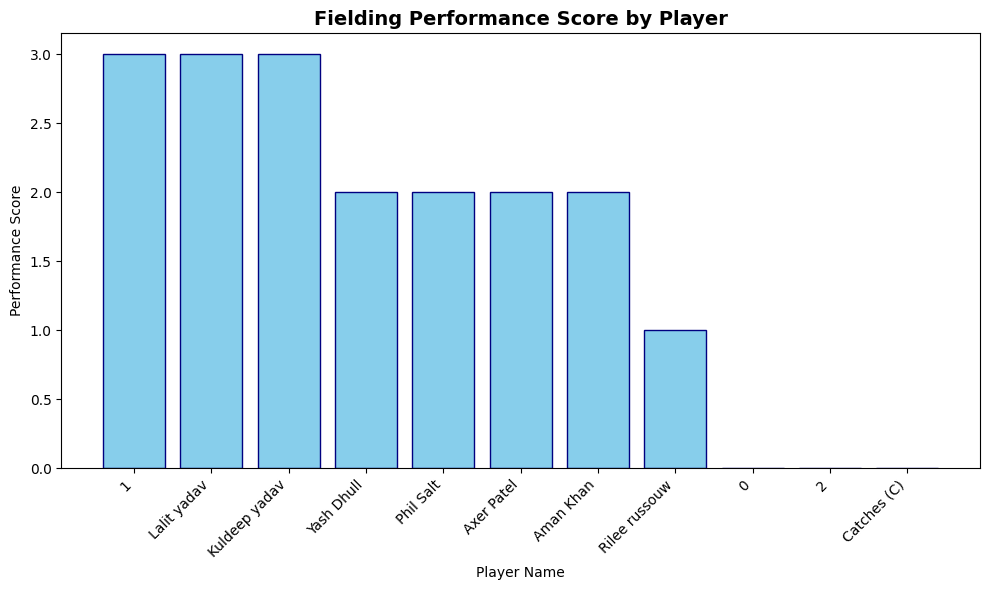

In [27]:
# Make sure player names are mapped to numeric positions for the bar plot
plt.figure(figsize=(10, 6))

player_performance_sorted = player_performance.sort_values('Performance Score', ascending=False)
x = np.arange(len(player_performance_sorted))  # Numeric positions for bars

plt.bar(x, player_performance_sorted['Performance Score'], color='skyblue', edgecolor='navy')
plt.title('Fielding Performance Score by Player', fontsize=14, fontweight='bold')
plt.xlabel('Player Name')
plt.ylabel('Performance Score')
plt.xticks(x, player_performance_sorted['Player Name'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Bar Plot for Phase-wise Grouped Bars**

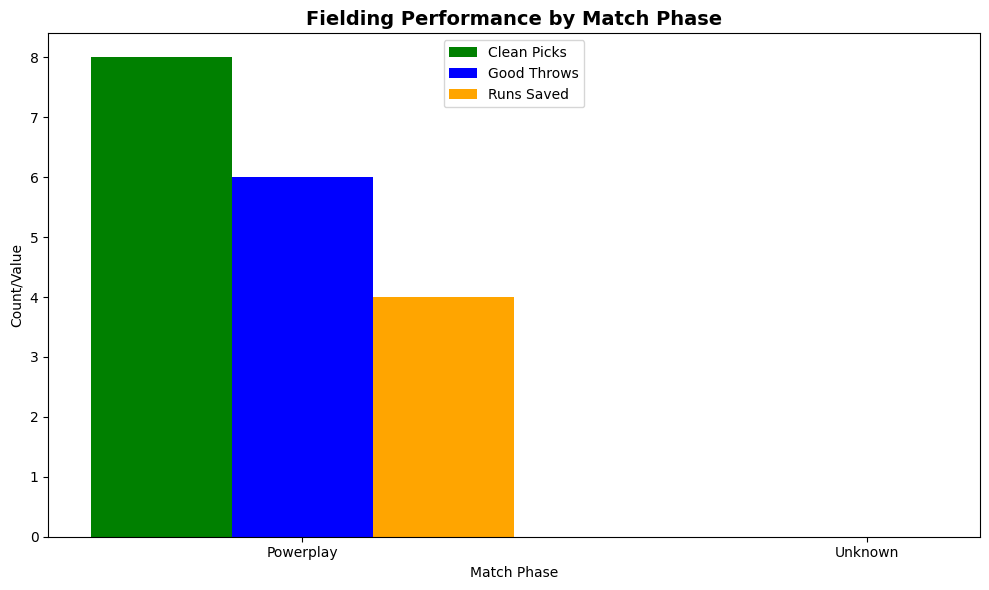

In [29]:
# For phase-wise grouped bars, ensure x is numeric index
fig, ax = plt.subplots(figsize=(10, 6))
phase_labels = list(phase_performance.index)
x = np.arange(len(phase_labels))
width = 0.25  # Make sure width is a numeric value

# Convert data to numeric if needed
clean_picks = pd.to_numeric(phase_performance['Clean Picks'], errors='coerce')
good_throws = pd.to_numeric(phase_performance['Good Throws'], errors='coerce')
runs_saved = pd.to_numeric(phase_performance['Runs Saved'], errors='coerce')

# Use the numeric data in the bar plots
ax.bar(x - width, clean_picks, width, label='Clean Picks', color='green')
ax.bar(x, good_throws, width, label='Good Throws', color='blue')
ax.bar(x + width, runs_saved, width, label='Runs Saved', color='orange')

ax.set_xlabel('Match Phase')
ax.set_ylabel('Count/Value')
ax.set_title('Fielding Performance by Match Phase', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(phase_labels)
ax.legend()
plt.tight_layout()
plt.show()

# Step 10: Generate Comprehensive Report and Export

In [30]:
def generate_report(player_performance, phase_performance, position_performance, output_file='fielding_report.csv'):
    """
    Generate comprehensive report and export to CSV
    """
    
    # Player Performance Report
    player_performance.to_csv('player_performance.csv', index=False)
    
    # Phase Performance Report
    phase_performance.to_csv('phase_performance.csv')
    
    # Position Performance Report
    position_performance.to_csv('position_performance.csv', index=False)
    
    print("\n✓ Reports generated successfully!")
    print("  - player_performance.csv")
    print("  - phase_performance.csv")
    print("  - position_performance.csv")
    
    # Print summary statistics
    print("\n" + "="*60)
    print("FIELDING PERFORMANCE ANALYSIS SUMMARY")
    print("="*60)
    print(f"\nTotal Players Analyzed: {len(player_performance)}")
    print(f"Best Performer: {player_performance.loc[player_performance['Performance Score'].idxmax(), 'Player Name']}")
    print(f"Highest Performance Score: {player_performance['Performance Score'].max()}")
    print(f"\nTotal Clean Picks: {player_performance['Clean Picks'].sum()}")
    print(f"Total Good Throws: {player_performance['Good Throws'].sum()}")
    print(f"Total Runs Saved: {player_performance['Runs Saved'].sum()}")
    print("\n" + "="*60)

# Execute report generation
generate_report(player_performance, phase_performance, position_performance)


✓ Reports generated successfully!
  - player_performance.csv
  - phase_performance.csv
  - position_performance.csv

FIELDING PERFORMANCE ANALYSIS SUMMARY

Total Players Analyzed: 11
Best Performer: 1
Highest Performance Score: 3.0

Total Clean Picks: 8
Total Good Throws: 6
Total Runs Saved: 4.0



# Complete Integration Script

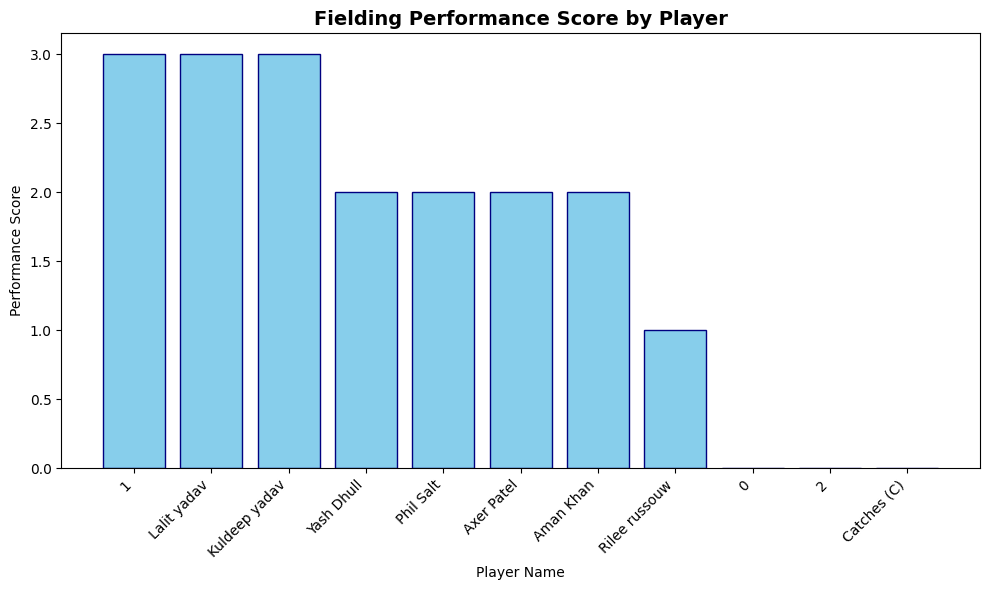

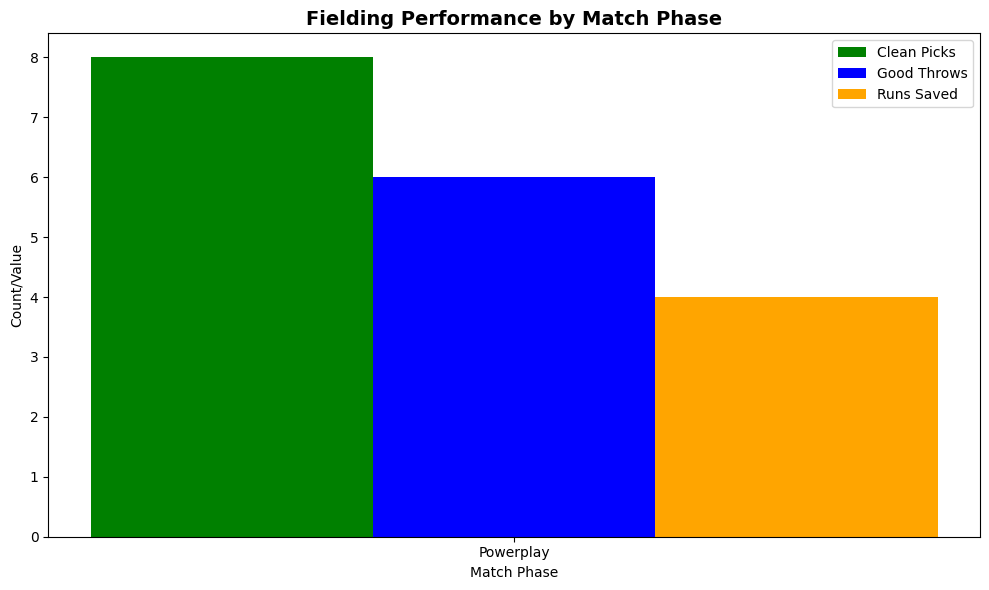

Player Performance:
      Player Name  Clean Picks  Good Throws  Runs Saved  Performance Score
1               1            0            0           3                  3
7     Lalit yadav            2            1           0                  3
6   Kuldeep yadav            2            1           0                  3
10     Yash Dhull            1            1           0                  2
8       Phil Salt            1            1           0                  2
4      Axer Patel            1            1           0                  2
3       Aman Khan            1            1           0                  2
9   Rilee russouw            0            0           1                  1
0               0            0            0           0                  0
2               2            0            0           0                  0
5     Catches (C)            0            0           0                  0

Phase-wise Summary:
       Phase  Clean Picks  Good Throws  Runs Saved
0  Power

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Load Data
df = pd.read_excel('IPL sample data.xlsx', sheet_name='Sheet1', skiprows=4)
df = df.dropna(how='all')
df = df[df['Player Name'].notna()].copy()

# STEP 2: Extract Fielding Events, Safely Cast Types
def extract_fielding_events(df):
    fielding_data = []
    for idx, row in df.iterrows():
        # Safe casting
        runs_val = pd.to_numeric(row['Runs'], errors='coerce')
        runs_val = 0 if pd.isna(runs_val) else runs_val

        over_val = pd.to_numeric(row['Overcount'], errors='coerce')
        over_val = 0 if pd.isna(over_val) else over_val

        fielding_data.append({
            'Player Name': row['Player Name'],
            'Clean Picks': 1 if str(row['Pick']).strip() == 'Y' else 0,
            'Good Throws': 1 if str(row['Throw']).strip() == 'Y' else 0,
            'Runs Saved': int(runs_val),
            'Over': over_val,
            'Position': row['Position']
        })
    events = pd.DataFrame(fielding_data)
    # Safe types for numeric columns
    events['Clean Picks'] = events['Clean Picks'].astype(int)
    events['Good Throws'] = events['Good Throws'].astype(int)
    events['Runs Saved'] = events['Runs Saved'].astype(int)
    events['Over'] = pd.to_numeric(events['Over'], errors='coerce').fillna(0)
    return events

fielding_events = extract_fielding_events(df)

# STEP 3: Calculate Player Performance
player_stats = fielding_events.groupby('Player Name').agg({
    'Clean Picks': 'sum',
    'Good Throws': 'sum',
    'Runs Saved': 'sum'
}).reset_index()

player_stats['Performance Score'] = (
    (player_stats['Clean Picks'] * 1) +
    (player_stats['Good Throws'] * 1) +
    player_stats['Runs Saved']
)

# STEP 4: Phase Analysis
def assign_phase(over):
    if pd.isna(over):
        return 'Unknown'
    over = float(over)
    return 'Powerplay' if over <= 6 else ('Middle Overs' if over <= 15 else 'Death Overs')

fielding_events['Phase'] = fielding_events['Over'].apply(assign_phase)
phase_summary = fielding_events.groupby('Phase')[['Clean Picks', 'Good Throws', 'Runs Saved']].sum().reset_index()

# STEP 5: Bar Plot for Player Performance (Corrected)
plt.figure(figsize=(10, 6))
player_stats_sorted = player_stats.sort_values('Performance Score', ascending=False)
x = np.arange(len(player_stats_sorted))  # Numeric positions for bars

plt.bar(x, player_stats_sorted['Performance Score'], color='skyblue', edgecolor='navy')
plt.title('Fielding Performance Score by Player', fontsize=14, fontweight='bold')
plt.xlabel('Player Name')
plt.ylabel('Performance Score')
plt.xticks(x, player_stats_sorted['Player Name'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# STEP 6: Bar Plot for Phase-wise Grouped Bars (Corrected)
fig, ax = plt.subplots(figsize=(10, 6))
phase_labels = list(phase_summary['Phase'])
x = np.arange(len(phase_labels))
width = 0.25

ax.bar(x - width, phase_summary['Clean Picks'], width, label='Clean Picks', color='green')
ax.bar(x, phase_summary['Good Throws'], width, label='Good Throws', color='blue')
ax.bar(x + width, phase_summary['Runs Saved'], width, label='Runs Saved', color='orange')

ax.set_xlabel('Match Phase')
ax.set_ylabel('Count/Value')
ax.set_title('Fielding Performance by Match Phase', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(phase_labels)
ax.legend()
plt.tight_layout()
plt.show()

# STEP 7: Export Results
player_stats.to_csv('player_performance.csv', index=False)
phase_summary.to_csv('phase_performance.csv', index=False)

print("Player Performance:")
print(player_stats_sorted)
print("\nPhase-wise Summary:")
print(phase_summary)